In [3]:
#Imports & config
#  Libraries

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import joblib   # optional: for saving models

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

#----------
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, classification_report
)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
#-------------------
# configure output folders
ROOT = Path.cwd()   # adjust if notebook root differs
DATA_DIR = ROOT / "data"
VIS_DIR = ROOT / "visuals"
SQL_DIR = ROOT / "sql"
DATA_DIR.mkdir(exist_ok=True)
VIS_DIR.mkdir(exist_ok=True)
SQL_DIR.mkdir(exist_ok=True)


In [4]:
#1 Load
csv_path = Path("../data/bank_loan_dataset.csv")
df = pd.read_csv(csv_path)

In [5]:
print(df.head())

    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2             1.0   

In [6]:
# quick peek
display(df.head(10))

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


In [7]:
df.shape

(614, 13)

In [8]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [10]:
# Try couple encodings and low_memory handling
for enc in (None, "utf-8", "utf-8-sig", "latin1"):
    try:
        df = pd.read_csv(csv_path, encoding=enc, low_memory=False)
        print(f"Loaded with encoding={enc}, shape={df.shape}")
        break
    except Exception as e:
        last_err = e
else:
    raise last_err

Loaded with encoding=None, shape=(614, 13)


In [11]:
# 2) Schema / missing / dtypes summary
def schema_summary(df):
    s = []
    for c in df.columns:
        ser = df[c]
        s.append({
            "column": c,
            "dtype": str(ser.dtype),
            "non_null": int(ser.notna().sum()),
            "nulls": int(ser.isna().sum()),
            "null_pct": round(100 * ser.isna().mean(), 2),
            "n_unique": int(ser.nunique(dropna=True)),
            "sample_values": ", ".join(map(str, ser.dropna().unique()[:5]))
        })
    return pd.DataFrame(s).sort_values(["null_pct", "n_unique"], ascending=[False, False])

ss = schema_summary(df)
display(ss)
ss.to_csv(DATA_DIR / "data_dictionary_summary.csv", index=False)
print("Saved data_dictionary_summary.csv")

,column,dtype,non_null,nulls,null_pct,n_unique,sample_values
10,Credit_History,float64,564,50,8.14,2,"1.0, 0.0"
5,Self_Employed,object,582,32,5.21,2,"No, Yes"
8,LoanAmount,float64,592,22,3.58,203,"128.0, 66.0, 120.0, 141.0, 267.0"
3,Dependents,object,599,15,2.44,4,"0, 1, 2, 3+"
9,Loan_Amount_Term,float64,600,14,2.28,10,"360.0, 120.0, 240.0, 180.0, 60.0"
1,Gender,object,601,13,2.12,2,"Male, Female"
2,Married,object,611,3,0.49,2,"No, Yes"
0,Loan_ID,object,614,0,0.00,614,"LP001002, LP001003, LP001005, LP001006, LP001008"
6,ApplicantIncome,int64,614,0,0.00,505,"5849, 4583, 3000, 2583, 6000"
7,CoapplicantIncome,float64,614,0,0.00,287,"0.0, 1508.0, 2358.0, 4196.0, 1516.0"


Saved data_dictionary_summary.csv


In [12]:
# 3) Detect target column heuristically and show class balance
target_candidates = ["Loan_Status","loan_status","LoanStatus","LoanStatus","Status","default","Default","is_default","isDefault"]
target_col = None
for t in target_candidates:
    if t in df.columns:
        target_col = t
        break

if target_col is None:
    # try fuzzy match (case-insensitive contains)
    for c in df.columns:
        if any(tok.lower() in c.lower() for tok in ["loan", "status", "default", "is_default"]):
            target_col = c
            break

print("Detected target:", target_col)
if target_col:
    print(df[target_col].value_counts(dropna=False))


Detected target: Loan_Status
Loan_Status
Y    422
N    192
Name: count, dtype: int64


In [13]:
# 4) Coerce numeric-like columns to numeric where appropriate
# If a column is object but many values convert to numbers, convert it.
def coerce_numeric_like(df, threshold=0.5):
    convert_cols = []
    for c in df.columns:
        if df[c].dtype == "object":
            conv = pd.to_numeric(df[c].str.replace(",", "").str.strip(), errors="coerce")
            non_null_frac = conv.notna().mean()
            if non_null_frac >= threshold:
                df[c] = conv
                convert_cols.append(c)
    return convert_cols

converted = coerce_numeric_like(df, threshold=0.4)
print("Converted to numeric:", converted)


Converted to numeric: ['Dependents']


In [14]:
# 5) Feature engineering (common Kaggle loan features)
df = df.copy()  # avoid SettingWithCopy
# Examples for common Kaggle columns; adapt if your names differ:
if "ApplicantIncome" in df.columns and "CoapplicantIncome" in df.columns:
    df["TotalIncome"] = df["ApplicantIncome"].fillna(0) + df["CoapplicantIncome"].fillna(0)
elif "ApplicantIncome" in df.columns:
    df["TotalIncome"] = df["ApplicantIncome"].fillna(0)

# LoanAmount and Loan_Amount_Term to EMI approximation
if "LoanAmount" in df.columns and "Loan_Amount_Term" in df.columns:
    # ensure numeric
    df["LoanAmount"] = pd.to_numeric(df["LoanAmount"], errors="coerce")
    df["Loan_Amount_Term"] = pd.to_numeric(df["Loan_Amount_Term"], errors="coerce")
    # EMI ≈ LoanAmount / Loan_Amount_Term (if term measured in months)
    df["EMI_proxy"] = df["LoanAmount"] / df["Loan_Amount_Term"].replace(0, np.nan)

# DTI (proxy)
if "LoanAmount" in df.columns and "TotalIncome" in df.columns:
    # protect divide by zero
    df["DTI_proxy"] = df["LoanAmount"] / df["TotalIncome"].replace(0, np.nan)

display(df[ [c for c in ["TotalIncome","EMI_proxy","DTI_proxy"] if c in df.columns] ].head())


,TotalIncome,EMI_proxy,DTI_proxy
0,5849.0,NaN,NaN
1,6091.0,0.355556,0.021015
2,3000.0,0.183333,0.022000
3,4941.0,0.333333,0.024287
4,6000.0,0.391667,0.023500


In [15]:
# 6) Missing value handling and light preprocessing (pre-model)
# Drop obvious ID columns if exist
for id_col in ["Loan_ID","loan_id","ID","id"]:
    if id_col in df.columns:
        df = df.drop(columns=[id_col])

# Separate column types
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols and c != target_col]

print("Numeric cols:", num_cols)
print("Categorical cols (sample):", cat_cols[:10])

# Impute strategy: numeric->median, categorical->mode (simple)
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

# Build column transformer
preprocessor = ColumnTransformer(transformers=[
    ("num", Pipeline([("imputer", num_imputer), ("scaler", StandardScaler())]), num_cols),
    ("cat", Pipeline([("imputer", cat_imputer), ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))]), cat_cols)
], remainder="drop")


Numeric cols: ['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'TotalIncome', 'EMI_proxy', 'DTI_proxy']
Categorical cols (sample): ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']


Logistic Regression metrics: {'accuracy': 0.8617886178861789, 'precision': 0.84, 'recall': 0.9882352941176471, 'f1': 0.9081081081081082, 'roc_auc': 0.8724458204334367}
Random Forest metrics: {'accuracy': 0.8536585365853658, 'precision': 0.8764044943820225, 'recall': 0.9176470588235294, 'f1': 0.896551724137931, 'roc_auc': 0.8642414860681116}


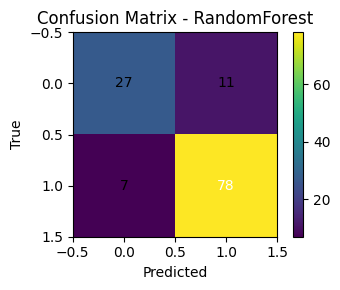

Saved cleaned dataset to: C:\Users\PC\Desktop\Data Analysis and VIsualization\A\Bank_Loan_Default_Risk_Analysis\notebooks\data\processed_bank_loan_clean.csv
Saved models & metrics.


In [16]:
# 7) If target exists and is binary -> run baseline models; else just save cleaned data
out_clean_path = DATA_DIR / "processed_bank_loan_clean.csv"

if target_col is None:
    # save cleaned dataset (no modeling)
    # impute numeric and categorical for a saved processed CSV
    df_clean = df.copy()
    # simple impute
    for c in num_cols:
        df_clean[c] = df_clean[c].fillna(df_clean[c].median())
    for c in cat_cols:
        df_clean[c] = df_clean[c].fillna(df_clean[c].mode().iloc[0] if not df_clean[c].mode().empty else "Unknown")
    df_clean.to_csv(out_clean_path, index=False)
    print("No target detected. Saved cleaned dataset to:", out_clean_path)

else:
    # prepare y
    y = df[target_col].copy()
    # Common Kaggle labels: 'Y'/'N' or 'Yes'/'No' -> map default to 1
    mapping_done = False
    if y.dtype == object:
        uniq = list(y.dropna().unique())
        if set(map(str.lower, uniq)) >= {"y","n"} or set(map(str.lower, uniq)) >= {"yes","no"}:
            # try to map 'Y'/'Yes' -> 1 (defaulter) and others to 0
            y = y.str.lower().map(lambda s: 1 if str(s).lower() in ("y","yes","1","true","t") else 0)
            mapping_done = True
    if not mapping_done:
        # fallback: factorize if binary
        if y.nunique(dropna=True) == 2:
            y, _ = pd.factorize(y)
        else:
            # if non-binary, stop modeling (or use multiclass)
            print("Target not binary. Target unique values:", y.unique())
            # still save cleaned dataset for analysis
            df.to_csv(out_clean_path, index=False)
            print("Saved cleaned data (no model).")
            raise SystemExit("Modeling skipped: target not binary.")

    # Prepare feature matrix X (drop original target col)
    X = df.drop(columns=[target_col])

    # Fit preprocessor and transform
    X_pre = preprocessor.fit_transform(X)
    # get feature names (for RF importance) - approximate
    # For large one-hot this may be heavy; we will not reconstruct full names in this quickstart.

    # Split (stratify only if y has >1 class)
    if len(np.unique(y)) < 2:
        raise SystemExit("Not enough classes to train model.")
    X_train, X_test, y_train, y_test = train_test_split(X_pre, y, test_size=0.2, random_state=42, stratify=y)

    # Baseline models
    lr = LogisticRegression(max_iter=2000)
    rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

    lr.fit(X_train, y_train)
    rf.fit(X_train, y_train)

    # Predictions
    y_pred_lr = lr.predict(X_test)
    y_pred_rf = rf.predict(X_test)

    # Probabilities (if available)
    try:
        y_prob_lr = lr.predict_proba(X_test)[:,1]
    except Exception:
        y_prob_lr = None
    try:
        y_prob_rf = rf.predict_proba(X_test)[:,1]
    except Exception:
        y_prob_rf = None

    def metrics(y_true, y_pred, y_proba=None):
        out = {
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred, zero_division=0),
            "recall": recall_score(y_true, y_pred, zero_division=0),
            "f1": f1_score(y_true, y_pred, zero_division=0)
        }
        if y_proba is not None:
            try:
                out["roc_auc"] = roc_auc_score(y_true, y_proba)
            except Exception:
                pass
        return out

    lr_metrics = metrics(y_test, y_pred_lr, y_prob_lr)
    rf_metrics = metrics(y_test, y_pred_rf, y_prob_rf)

    print("Logistic Regression metrics:", lr_metrics)
    print("Random Forest metrics:", rf_metrics)

    # Confusion matrix plot for RF (example)
    cm = confusion_matrix(y_test, y_pred_rf)
    plt.figure(figsize=(4,3))
    plt.imshow(cm, interpolation="nearest")
    plt.title("Confusion Matrix - RandomForest")
    plt.colorbar()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i,j], ha="center", va="center", color="white" if cm[i,j] > cm.max()/2 else "black")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(VIS_DIR / "confusion_matrix_rf.png")
    plt.show()

    # Save processed dataset (impute original df with simple rules so it can be used in Power BI)
    df_save = df.copy()
    for c in num_cols:
        df_save[c] = df_save[c].fillna(df_save[c].median())
    for c in cat_cols:
        df_save[c] = df_save[c].fillna(df_save[c].mode().iloc[0] if not df_save[c].mode().empty else "Unknown")
    df_save.to_csv(out_clean_path, index=False)
    print("Saved cleaned dataset to:", out_clean_path)

    # Save models & metrics
    joblib.dump(rf, DATA_DIR / "rf_baseline.joblib")
    joblib.dump(lr, DATA_DIR / "lr_baseline.joblib")
    (DATA_DIR / "metrics_report.txt").write_text(f"LR: {lr_metrics}\nRF: {rf_metrics}\n")
    print("Saved models & metrics.")


In [17]:
# 8) Run your SQL snippets against an in-memory SQLite DB (safe mapping)
# This avoids duplicate column-name problems: we use the dataframe column names directly.
conn = sqlite3.connect(":memory:")

# Ensure SQL-friendly column names (if duplicates exist with case-insensitively equal names,
# make them unique by appending _1, _2, etc.)
def make_unique(cols):
    out = []
    seen = {}
    for c in cols:
        base = c
        if base in seen:
            seen[base] += 1
            new = f"{base}_{seen[base]}"
        else:
            seen[base] = 0
            new = base
        out.append(new)
    return out

df_sql = df.copy()
df_sql.columns = make_unique(list(df_sql.columns))
df_sql.to_sql("bank_loans", conn, if_exists="replace", index=False)

# run the SQL queries you listed
queries = {
    "total_loans": "SELECT COUNT(*) AS total_loans FROM bank_loans;",
    "loan_approval_rate": """
        SELECT loan_status AS loan_status, COUNT(*) AS total
        FROM bank_loans
        GROUP BY loan_status;
    """,
    "avg_income_by_status": """
        SELECT loan_status AS loan_status, AVG(applicant_income) AS avg_income
        FROM bank_loans
        GROUP BY loan_status;
    """,
    "dti_risk_segmentation": """
        SELECT
            CASE
                WHEN debt_to_income < 0.2 THEN 'Low Risk'
                WHEN debt_to_income BETWEEN 0.2 AND 0.4 THEN 'Medium Risk'
                ELSE 'High Risk'
            END AS risk_category,
            COUNT(*) AS applicants
        FROM bank_loans
        GROUP BY risk_category;
    """
}

for name, q in queries.items():
    try:
        res = pd.read_sql_query(q, conn)
        print(f"--- {name} ---")
        display(res)
    except Exception as e:
        print(f"Query {name} failed: {e}")


--- total_loans ---


,total_loans
0,614


--- loan_approval_rate ---


,loan_status,total
0,N,192
1,Y,422


Query avg_income_by_status failed: Execution failed on sql '
        SELECT loan_status AS loan_status, AVG(applicant_income) AS avg_income
        FROM bank_loans
        GROUP BY loan_status;
    ': no such column: applicant_income
Query dti_risk_segmentation failed: Execution failed on sql '
        SELECT
            CASE
                WHEN debt_to_income < 0.2 THEN 'Low Risk'
                WHEN debt_to_income BETWEEN 0.2 AND 0.4 THEN 'Medium Risk'
                ELSE 'High Risk'
            END AS risk_category,
            COUNT(*) AS applicants
        FROM bank_loans
        GROUP BY risk_category;
    ': no such column: debt_to_income


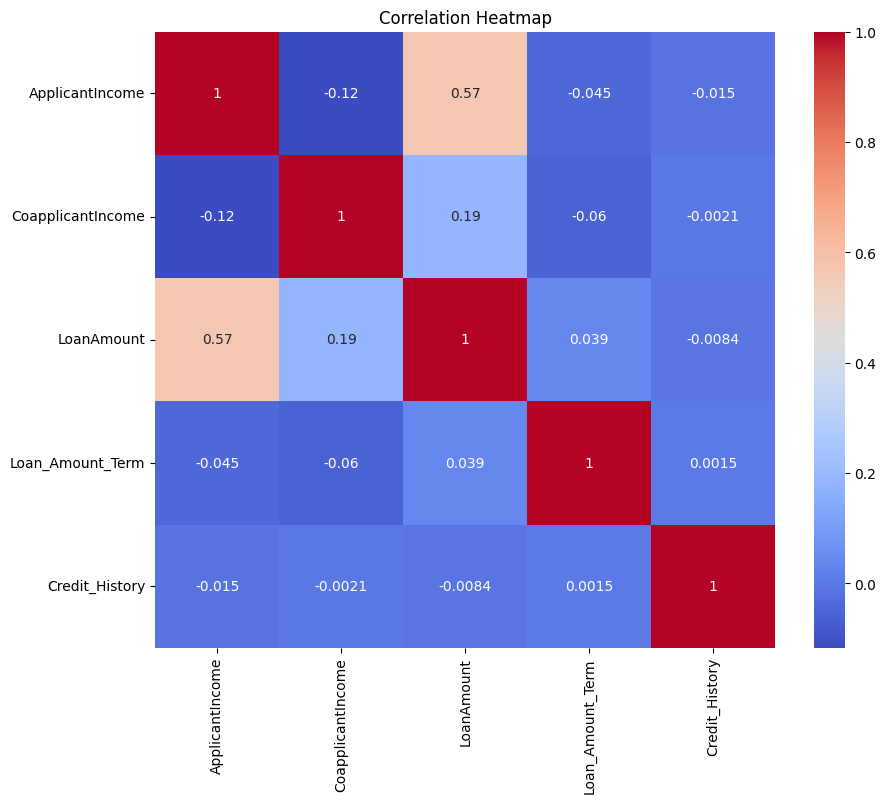

In [46]:
corr = df.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig('../visuals/correlation_heatmap.png')
plt.show()

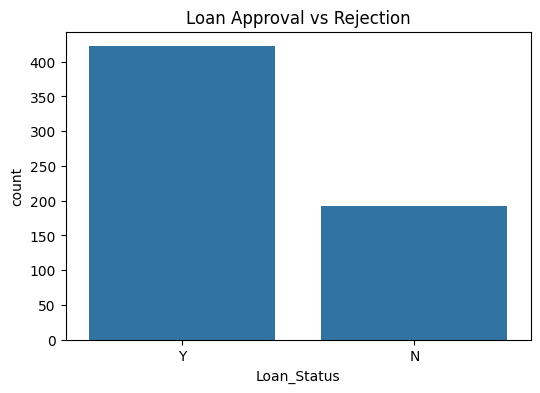

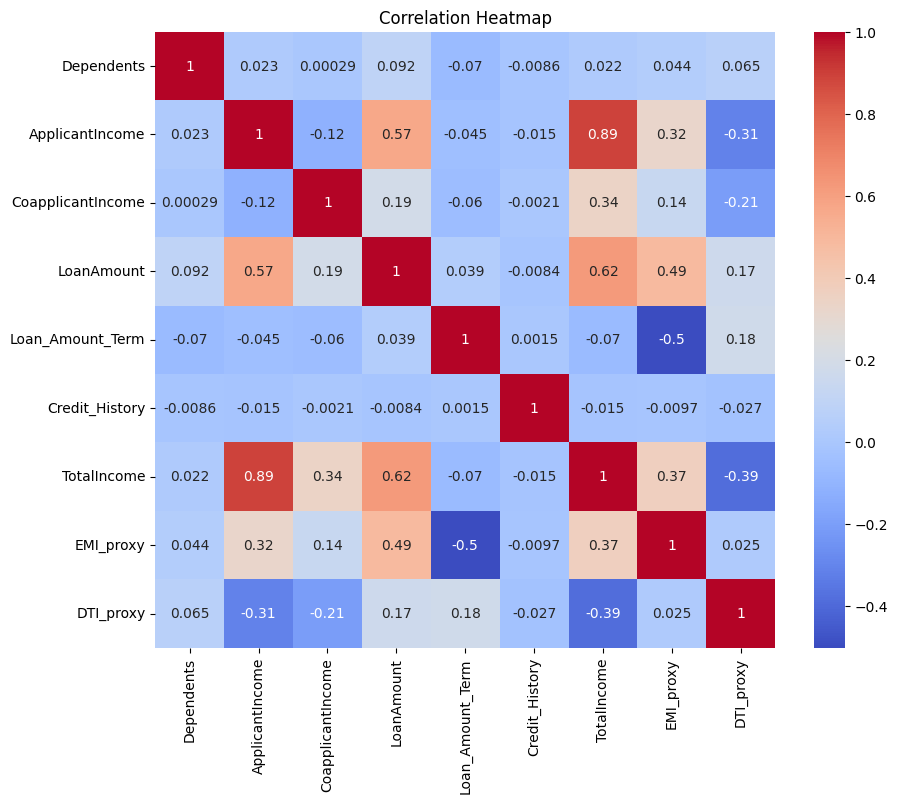

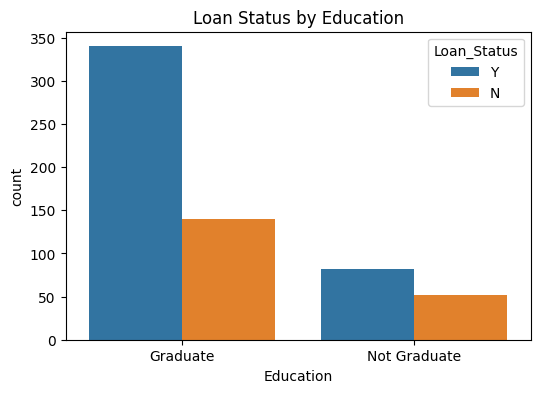

In [18]:
#9 Exploratory Data Analysis
# Loan Status Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Loan_Status', data=df)
plt.title("Loan Approval vs Rejection")
plt.savefig("../visuals/loan_status_distribution.png")
plt.show()

# Correlation Heatmap (numeric only)
numeric_df = df.select_dtypes(include=['int64', 'float64'])  # keep only numeric columns
corr = numeric_df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.savefig("../visuals/correlation_heatmap.png")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='Education', hue='Loan_Status', data=df)
plt.title("Loan Status by Education")
plt.savefig("../visuals/Loan_Status_by_Education.png")
plt.show()


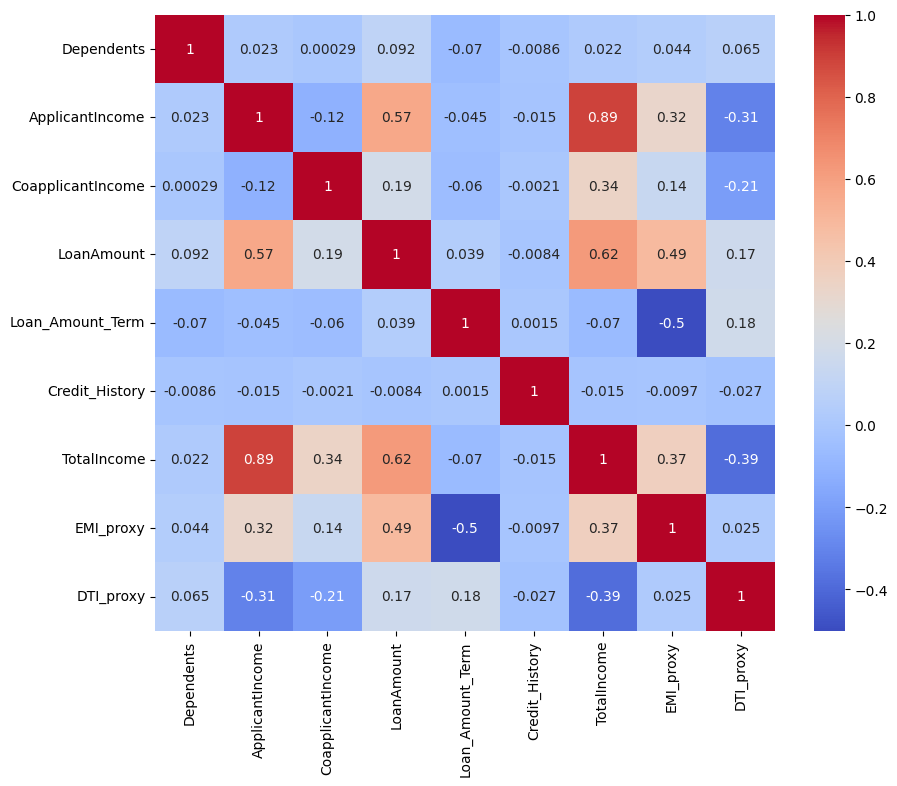

In [19]:
# Create a new DataFrame with only the numerical columns
numeric_df = df.select_dtypes(include=['number'])

# Calculate the correlation matrix
corr = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

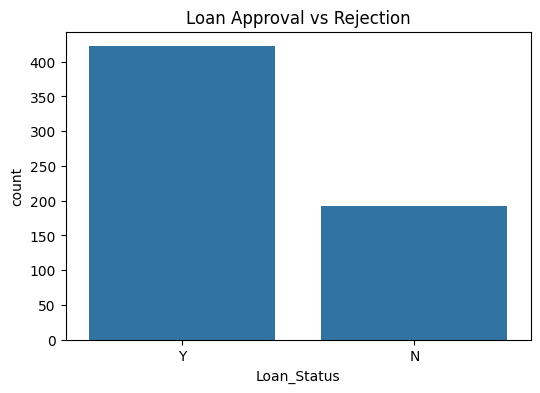

In [20]:
#10) EDA - Understand Dataset

# Loan status distribution
plt.figure(figsize=(6,4))
sns.countplot(x="Loan_Status", data=df)
plt.title("Loan Approval vs Rejection")
plt.show()

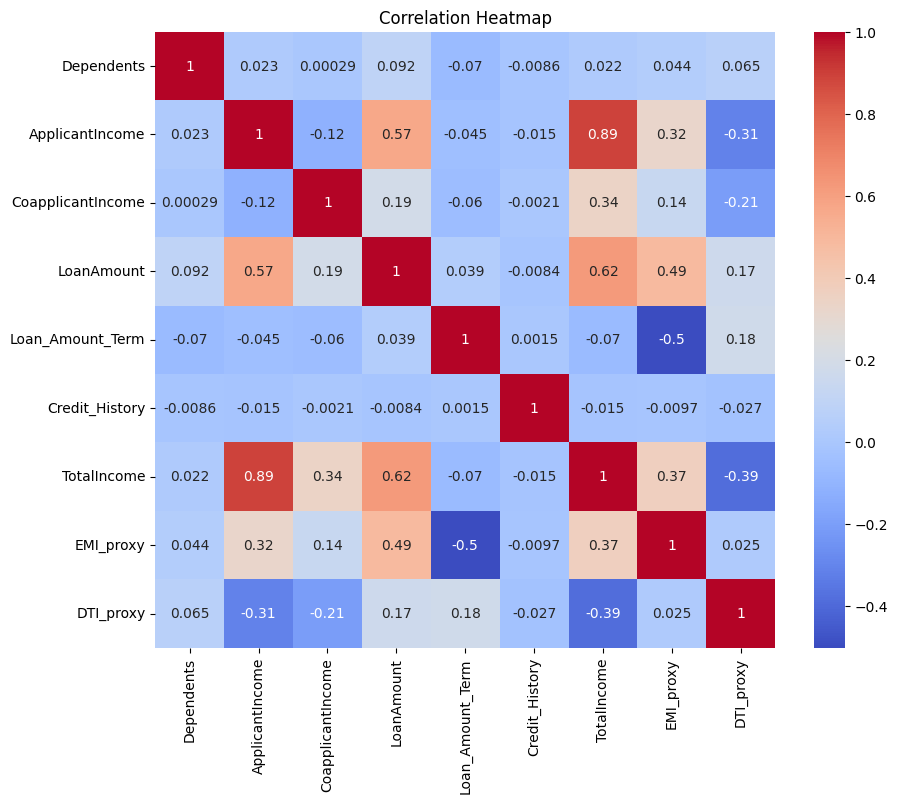

In [21]:
# Numeric correlations
numeric_df = df.select_dtypes(include=["int64","float64"])
plt.figure(figsize=(10,8))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

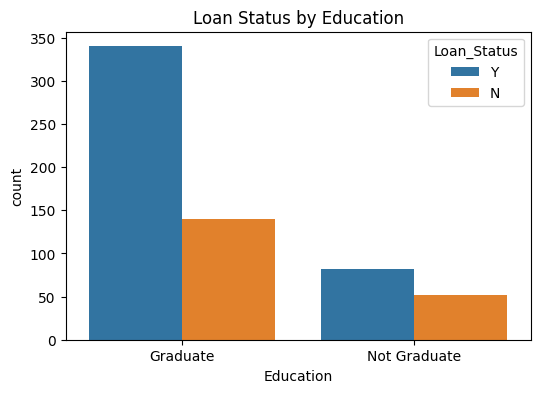

In [22]:
# Education vs Loan Status
plt.figure(figsize=(6,4))
sns.countplot(x="Education", hue="Loan_Status", data=df)
plt.title("Loan Status by Education")
plt.show()

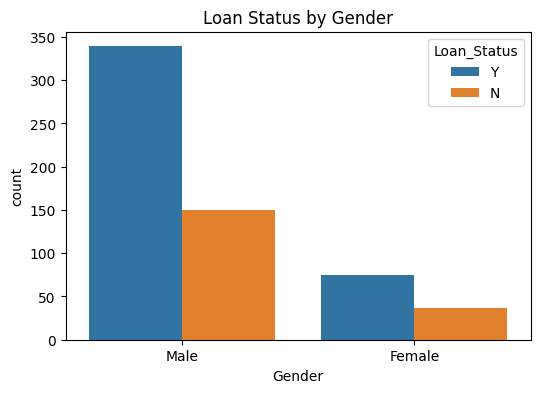

In [23]:
#11) Risk & Bias Analysis

# Gender bias
plt.figure(figsize=(6,4))
sns.countplot(x="Gender", hue="Loan_Status", data=df)
plt.title("Loan Status by Gender")
plt.show()


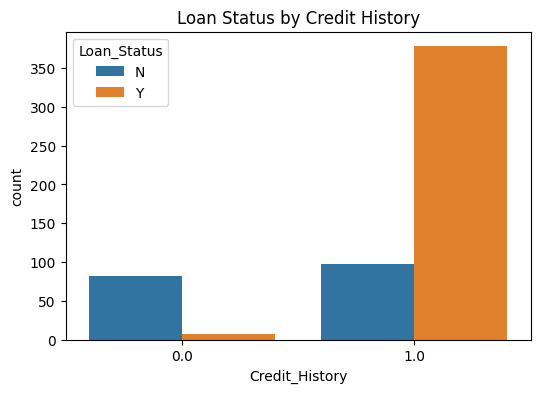

In [24]:
# Credit history effect
plt.figure(figsize=(6,4))
sns.countplot(x="Credit_History", hue="Loan_Status", data=df)
plt.title("Loan Status by Credit History")
plt.show()

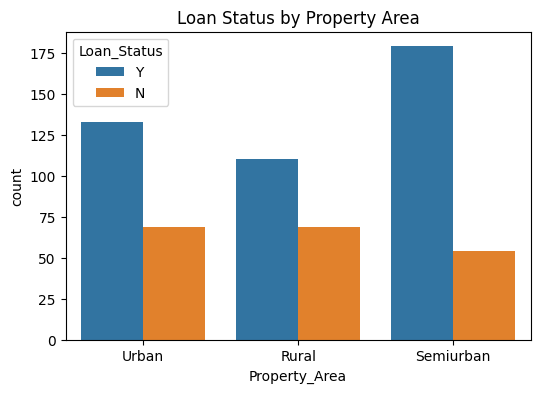

In [25]:
# Property area effect
plt.figure(figsize=(6,4))
sns.countplot(x="Property_Area", hue="Loan_Status", data=df)
plt.title("Loan Status by Property Area")
plt.show()

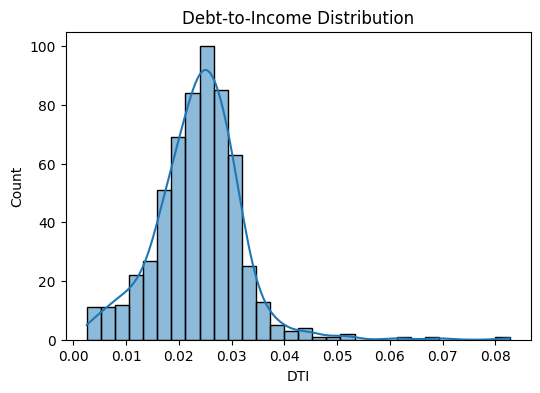

In [26]:
#12) Financial Ratios
# Create Total Income
df["TotalIncome"] = df["ApplicantIncome"].fillna(0) + df["CoapplicantIncome"].fillna(0)

# EMI
df["EMI"] = df["LoanAmount"] / df["Loan_Amount_Term"].replace(0, np.nan)

# Debt-to-Income Ratio (DTI)
df["DTI"] = df["LoanAmount"] / df["TotalIncome"].replace(0, np.nan)

plt.figure(figsize=(6,4))
sns.histplot(df["DTI"], bins=30, kde=True)
plt.title("Debt-to-Income Distribution")
plt.show()

In [27]:
# 13. Predictive Models

# Prepare dataset
target = "Loan_Status"
X = df.drop(columns=[target, "Loan_ID"], errors="ignore")
y = df[target].map({"Y":1, "N":0})  # convert categorical target

In [28]:
# One-hot encode categoricals
X = pd.get_dummies(X, drop_first=True)

In [29]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [30]:
#14) Logistic Regression
# Create a sample dataset
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Logistic Regression model
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = lr.predict(X_test)

# Print the accuracy
print("LogReg Accuracy:", accuracy_score(y_test, y_pred_lr))

LogReg Accuracy: 0.855


In [31]:
#15) Random Forest
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("RandomForest Accuracy:", accuracy_score(y_test, y_pred_rf))


RandomForest Accuracy: 0.9


In [32]:
# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

XGBoost Accuracy: 0.895


C:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:44:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [33]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")

In [34]:
y_pred_xgb = xgb.predict(X_test)

NotFittedError: need to call fit or load_model beforehand

In [35]:
    xgb.fit(X_train, y_train)

C:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:44:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [36]:
    y_pred_xgb = xgb.predict(X_test)

In [37]:
    print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

XGBoost Accuracy: 0.895


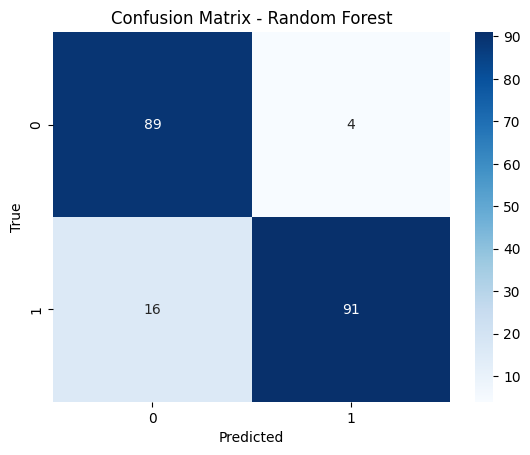

In [38]:
# Confusion matrix for RF
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

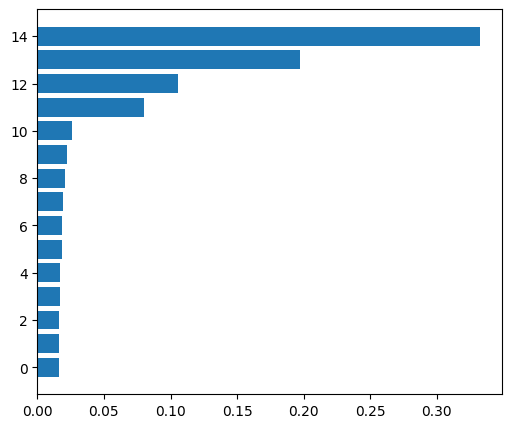

In [39]:
# Feature Importance (Random Forest)
importances = rf.feature_importances_
idx = np.argsort(importances)[-15:]
plt.figure(figsize=(6,5))
plt.barh(range(len(idx)), importances[idx])
# Use X.columns directly
plt.yticks(range(len(idx)), [X.columns[i] for i in idx])
plt.title("Top 15 Features - Random Forest")
plt.show()

In [40]:
# Save cleaned dataset + clusters for Power BI / Tableau
df.to_csv("../data/processed_bank_loan_with_clusters.csv", index=False)
print("Processed dataset saved for dashboarding ✅")

Processed dataset saved for dashboarding ✅
